In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import tensorflow as tf
import numpy as np
import gym
from tqdm import tqdm, trange
import os, sys
sys.path.append(os.getcwd())

Populating the interactive namespace from numpy and matplotlib


In [2]:
class TicTacToe():
    def __init__(self, state=None):
        self.reset()
        if state is not None:
            self.state = state
        
    def reset(self):
        self.done = False
        self.state = [0]*11
        self.state[-1] = 1
        return self.state
    
    class observation_space():
        shape = (11,)

    class action_space():
        n = 9

    def render(self):
        # print whose turn it is when we render to look at what
        # muzero thinks is a losing game
        print("turn %d" % self.state[-1])
        print(np.array(self.state[0:9]).reshape(3,3))
    
    def value(self, s):
        ret = 0
        for turn in [-1, 1]:
            for i in range(3):
                if all([x==turn for x in s[3*i:3*i+3]]):
                    ret = turn
                if all([x==turn for x in [s[i], s[3+i], s[6+i]]]):
                    ret = turn
                if all([x==turn for x in [s[0], s[4], s[8]]]):
                    ret = turn
                if all([x==turn for x in [s[2], s[4], s[6]]]):
                    ret = turn
        # NOTE: this is not the value, the state may be won
        return ret*s[-1]

    def dynamics(self, s, act):
        rew = 0
        s = s.copy()
        if s[act] != 0 or s[-2] != 0:
          # don't move in taken spots or in finished games
          rew = -10
        else:
            s[act] = s[-1]
            rew += self.value(s)
        if s[-2] != 0:
            rew = 0
        else:
            s[-2] = self.value(s)
        s[-1] = -s[-1]
        return rew, s

    def step(self, act):
        rew, self.state = self.dynamics(self.state, act)
        if rew != 0:
            self.done = True
        if np.all(np.array(self.state[0:9]) != 0):
            self.done = True
        return self.state, rew, self.done, None

In [3]:
env = TicTacToe()

In [4]:
env.render()

turn 1
[[0 0 0]
 [0 0 0]
 [0 0 0]]


In [5]:
from muzero.model import MuModel
m = MuModel(env.observation_space.shape, env.action_space.n, s_dim=64, K=5, lr=0.001)
print(env.observation_space.shape, env.action_space.n)

from muzero.game import Game, ReplayBuffer
from muzero.mcts import naive_search, mcts_search
replay_buffer = ReplayBuffer(50, 128, m.K)
rews = []

(11,) 9


In [6]:
def play_game(env, m):
    import random
    game = Game(env, discount=0.99)
    while not game.terminal():
    # TODO: Do we need to limit the depth of the MCTS search?
    #policy = naive_search(m, game.observation, T=1)
        policy, _ = mcts_search(m, game.observation, 30)
        game.act_with_policy(policy)
    return game

In [7]:
from muzero.model import reformat_batch
import collections

for j in range(30):
    for i in range(10):
        game = play_game(env, m)
        replay_buffer.save_game(game)
        rew = sum(game.rewards)
        rews.append(rew)
    for i in range(10):
        m.train_on_batch(replay_buffer.sample_batch())
    print(len(game.history), rew, game.history, m.losses[-1][0])

6 -10 [2, 3, 4, 6, 8, 3] 161.3199920654297
3 -10 [2, 7, 2] 112.41104888916016
2 -10 [2, 2] 98.64979553222656
4 -10 [7, 0, 6, 6] 87.25556182861328
5 -10 [4, 0, 1, 6, 6] 94.87847900390625
7 -10 [5, 8, 0, 6, 7, 3, 3] 865.3579711914062
5 -10 [8, 2, 0, 4, 0] 229.09860229492188
5 1 [4, 5, 6, 3, 2] 162.84274291992188
5 -10 [4, 0, 8, 6, 6] 157.4864501953125
2 -10 [1, 1] 161.799072265625
4 -10 [6, 7, 3, 3] 140.22915649414062
2 -10 [6, 6] 146.46046447753906
8 -10 [1, 8, 6, 0, 7, 2, 3, 2] 156.47071838378906
4 -10 [3, 1, 0, 3] 154.7995147705078
6 -10 [7, 6, 0, 3, 5, 5] 456.5722961425781
4 -10 [8, 6, 7, 7] 237.15956115722656
6 -10 [7, 6, 1, 8, 0, 6] 206.40243530273438
2 -10 [7, 7] 70401.796875
2 -10 [4, 4] 779.29541015625
5 -10 [4, 5, 6, 3, 6] 200.1975555419922
4 -10 [5, 8, 0, 5] 176.00682067871094
2 -10 [0, 0] 152.3292694091797
5 -10 [3, 8, 6, 5, 8] 163.51441955566406
3 -10 [0, 6, 6] 130.34869384765625
6 -10 [2, 1, 0, 6, 3, 6] 145.0017852783203
2 -10 [6, 6] 120.65040588378906
2 -10 [6, 6] 117.5282

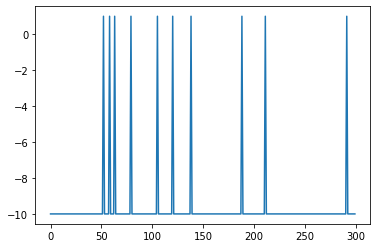

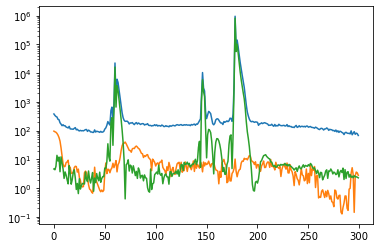

In [8]:
plot(rews)
figure()
plt.yscale('log')
plot([x[0] for x in m.losses])
plot([x[1] for x in m.losses])
plot([x[-3] for x in m.losses])

In [ ]:
def minimax(node):
    # for each action, do the step method effectively
    if env.value(s) != 0:
        return s[-1] * env.value(s)
    
    if s[-1] == 1:
        value = -float('inf')
        for a in range(9):
            rew, ns = env.dynamics(s, a)
            value = max(value, minimax(ns))
        if s[-1] == -1:
            value = float('inf')
            for a in range(9):
            rew, ns = env.dynamics(s, a)
            if s != ns:
                value = min(value, minimax(ns))

In [ ]:
s = env.reset()
minimax(s)